In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

In [2]:
columns = ["duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", "wrong_fragment", "urgent",
        "hot", "num_failed_logins", "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root", 
        "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login",
        "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
        "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count", 
        "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate",
        "dst_host_serror_rate", "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"]

df = pd.read_csv("kddcup.data.corrected", sep=",", names=columns, index_col=None)


In [3]:
df.shape

(4898431, 42)

In [4]:
df = df[df["service"] == "http"]
df = df.drop("service", axis=1)
columns.remove("service")

In [5]:
df.shape

(623091, 41)

In [6]:
df["label"].value_counts()

normal.       619046
back.           2203
neptune.        1801
portsweep.        16
ipsweep.          13
satan.             7
phf.               4
nmap.              1
Name: label, dtype: int64

In [7]:
df.head(5)

,duration,protocol_type,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,SF,215,45076,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,SF,162,4528,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,SF,236,1228,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,SF,233,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,SF,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,normal.


In [8]:
for col in df.columns:
    if df[col].dtype == "object":
        encoded = LabelEncoder()
        encoded.fit(df[col])
        df[col] = encoded.transform(df[col])

In [9]:
df.head(5)

,duration,protocol_type,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,0,9,215,45076,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,4
1,0,0,9,162,4528,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,4
2,0,0,9,236,1228,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,4
3,0,0,9,233,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,4
4,0,0,9,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,4


In [10]:
for f in range(0, 3):
    df = df.iloc[np.random.permutation(len(df))]
    
df2 = df[:500000]
labels = df2["label"]
df_validate = df[500000:]
x_train, x_test, y_train, y_test = train_test_split(df2, labels, test_size = 0.2, random_state = 42)

x_val, y_val = df_validate, df_validate["label"]

In [11]:
print("Shapes:\nx_train:%s\ny_train:%s\n" % (x_train.shape, y_train.shape))
print("x_test:%s\ny_test:%s\n" % (x_test.shape, y_test.shape))
print("x_val:%s\ny_val:%s\n" % (x_val.shape, y_val.shape))

Shapes:
x_train:(400000, 41)
y_train:(400000,)

x_test:(100000, 41)
y_test:(100000,)

x_val:(123091, 41)
y_val:(123091,)



In [12]:
#Insert your model code here; call your model "model"
from sklearn.ensemble import IsolationForest

model = IsolationForest(n_estimators=1000, max_samples=200, contamination=0.1, random_state=42)
model.fit(x_train)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


IsolationForest(contamination=0.1, max_samples=200, n_estimators=1000,
                random_state=42)

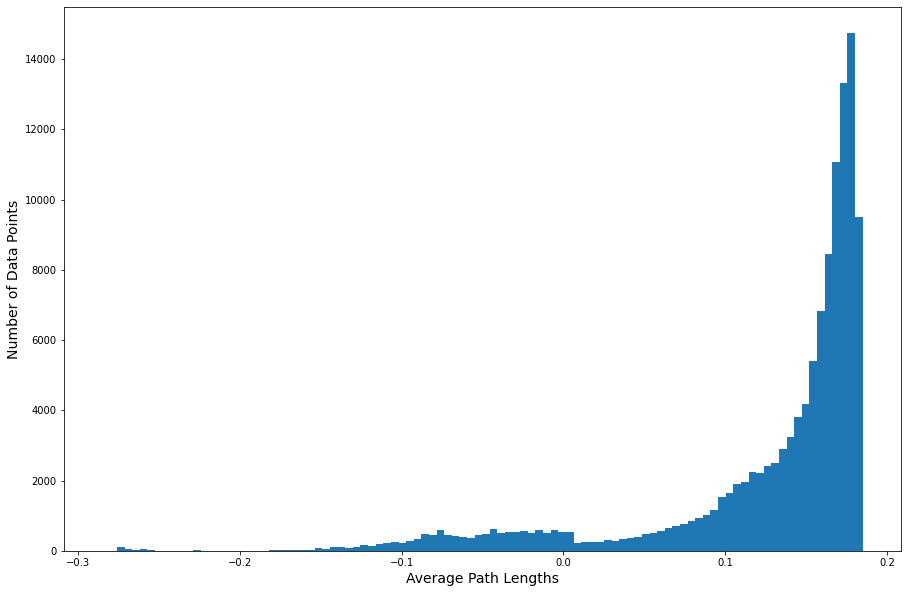

In [13]:
anomaly_scores = model.decision_function(x_val)
plt.figure(figsize=(15, 10))
plt.hist(anomaly_scores, bins=100)
plt.xlabel('Average Path Lengths', fontsize=14)
plt.ylabel('Number of Data Points', fontsize=14)
plt.show()

In [14]:
from sklearn.metrics import roc_auc_score

anomalies = anomaly_scores > -0.19
matches = y_val == list(encoded.classes_).index("normal.")
auc = roc_auc_score(anomalies, matches)
print("AUC: {:.2%}".format (auc))

AUC: 98.84%


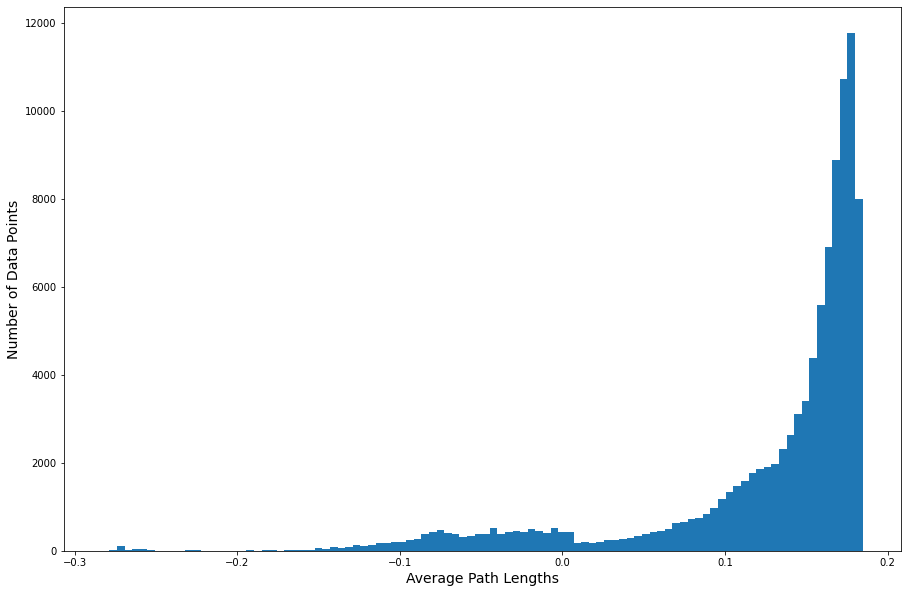

In [15]:
anomaly_scores_test = model.decision_function(x_test)
plt.figure(figsize=(15, 10))
plt.hist(anomaly_scores_test, bins=100)
plt.xlabel('Average Path Lengths', fontsize=14)
plt.ylabel('Number of Data Points', fontsize=14)
plt.show()

In [16]:
anomalies_test = anomaly_scores_test > -0.19
matches = y_test == list(encoded.classes_).index("normal.")
auc = roc_auc_score(anomalies_test, matches)
print("AUC: {:.2%}".format (auc))

AUC: 98.43%
